# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [11]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [12]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [13]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

In [215]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model
stop_words = set(stopwords.words('english'))

In [235]:
# FinBERT Models: Load model 1: ProsusAI/finbert
tokenizer_prosus = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model_prosus = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert').to(device)

In [222]:
# FinBERT Models: Load model 2: yiyanghkust/finbert-tone
tokenizer_yiyang = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_yiyang = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone').to(device)

In [17]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [18]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [21]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [22]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [24]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [25]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [26]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [27]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [28]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [29]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [32]:
# Load the CSV file as speeches.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches.head()

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


In [33]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [34]:
# Check for missing values.
speeches.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [35]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [36]:
# Review basic descriptive statistics.
speeches.describe()

,is_gov
count,7721.000000
mean,0.347235
std,0.476122
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [37]:
# Check the number of unique values.
speeches.nunique()

reference    7721
country         8
date         4410
title        6218
author        325
is_gov          2
text         7692
dtype: int64

In [38]:
# View the countries.
speeches['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [39]:
# View the author.
speeches['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Sentiment Label Lexicon**

**BoE Word List**

In [42]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0


In [43]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [44]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [45]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
count,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000
mean,0.606959,0.092268,0.076546,0.233247,0.004897,0.006959,0.047423
std,0.488489,0.289441,0.265905,0.422953,0.069815,0.083139,0.212569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Loughran-McDonald_MasterDictionary used primarily for financial and corporate sentiment analysis**

In [47]:
# Load the CSV file Loughran-McDonald_MasterDictionary.
loughran_mcdonald_dict = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/Loughran-McDonald_MasterDictionary_1993-2024.csv')

# View the data.
loughran_mcdonald_dict.head()

,Word,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity
0,AARDVARK,0,0,0,0,0,0,0,0
1,AARDVARKS,0,0,0,0,0,0,0,0
2,ABACI,0,0,0,0,0,0,0,0
3,ABACK,0,0,0,0,0,0,0,0
4,ABACUS,0,0,0,0,0,0,0,0


In [48]:
# Explore data set.
loughran_mcdonald_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86553 entries, 0 to 86552
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          86552 non-null  object
 1   Negative      86553 non-null  int64 
 2   Positive      86553 non-null  int64 
 3   Uncertainty   86553 non-null  int64 
 4   Litigious     86553 non-null  int64 
 5   Strong_Modal  86553 non-null  int64 
 6   Weak_Modal    86553 non-null  int64 
 7   Constraining  86553 non-null  int64 
 8   Complexity    86553 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 5.9+ MB


In [49]:
# Check for missing values.
loughran_mcdonald_dict.isnull().sum()

Word            1
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong_Modal    0
Weak_Modal      0
Constraining    0
Complexity      0
dtype: int64

In [50]:
# Select rows where any column has a null value
rows_with_nulls = loughran_mcdonald_dict[loughran_mcdonald_dict.isnull().any(axis=1)]

rows_with_nulls

,Word,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity
50748,NaN,0,0,0,0,0,0,0,0


**Observation**: as no word is associated with the empty cell in word, it does not impact the analysis.

In [52]:
# Review basic descriptive statistics.
loughran_mcdonald_dict.describe()

,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Complexity
count,86553.000000,86553.000000,86553.000000,86553.000000,86553.000000,86553.000000,86553.000000,86553.000000
mean,0.027093,0.004009,0.003431,0.010433,0.000220,0.000312,0.002126,0.000612
std,0.162356,0.063191,0.058478,0.101608,0.014815,0.017659,0.046058,0.024738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
# Check the number of unique values.
loughran_mcdonald_dict.nunique()

Word            86552
Negative            2
Positive            2
Uncertainty         2
Litigious           2
Strong_Modal        2
Weak_Modal          2
Constraining        2
Complexity          2
dtype: int64

In [54]:
# Rename the confidence index column.
loughran_mcdonald_dict.rename(columns={'Negative': 'negative_lm', 'Positive': 'positive_lm', 'Uncertainty': 'uncertainty_lm', \
                                       'Litigious': 'litigious_lm', 'Strong_Modal': 'strong_lm', 'Weak_Modal': 'weak_lm', \
                                       'Constraining': 'constraining_lm', 'Complexity': 'complexity_lm' }, inplace=True)

# View the DataFrame.
loughran_mcdonald_dict.head()

,Word,negative_lm,positive_lm,uncertainty_lm,litigious_lm,strong_lm,weak_lm,constraining_lm,complexity_lm
0,AARDVARK,0,0,0,0,0,0,0,0
1,AARDVARKS,0,0,0,0,0,0,0,0
2,ABACI,0,0,0,0,0,0,0,0
3,ABACK,0,0,0,0,0,0,0,0
4,ABACUS,0,0,0,0,0,0,0,0


**2.3.c. Import Economic Indicators**

**Inflation**

In [57]:
# Load the CSV file as speeches.
inflation_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Historical data on UK inflation.xlsx')

# View the data.
inflation_uk_org.head()

,Year,1,2,3,4,5,6,7,8,9,10,11,12,Annual
0,2025,0.02983,0.02836,0.02594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,0.03981,0.03411,0.03228,0.02333,0.01990,0.01975,0.02234,0.02216,0.01680,0.02281,0.02622,0.02503,0.02530
2,2023,0.10052,0.10416,0.10057,0.08658,0.08681,0.07950,0.06827,0.06657,0.06652,0.04600,0.03941,0.03993,0.07303
3,2022,0.05456,0.06177,0.07023,0.09011,0.09083,0.09412,0.10101,0.09870,0.10096,0.11052,0.10672,0.10528,0.09067
4,2021,0.00701,0.00414,0.00714,0.01526,0.02115,0.02514,0.02040,0.03197,0.03080,0.04206,0.05130,0.05386,0.02588


In [58]:
# Drop column 'Annual'.
inflation_uk_org = inflation_uk_org.drop(columns=['Annual'])

# View the data.
inflation_uk_org.head()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
0,2025,0.02983,0.02836,0.02594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024,0.03981,0.03411,0.03228,0.02333,0.01990,0.01975,0.02234,0.02216,0.01680,0.02281,0.02622,0.02503
2,2023,0.10052,0.10416,0.10057,0.08658,0.08681,0.07950,0.06827,0.06657,0.06652,0.04600,0.03941,0.03993
3,2022,0.05456,0.06177,0.07023,0.09011,0.09083,0.09412,0.10101,0.09870,0.10096,0.11052,0.10672,0.10528
4,2021,0.00701,0.00414,0.00714,0.01526,0.02115,0.02514,0.02040,0.03197,0.03080,0.04206,0.05130,0.05386


In [59]:
# Transpose the DataFrame.
# The first row is treated as the header forthe DataFrame
inflation_uk_transposed = inflation_uk_org.melt(id_vars=["Year"], 
                        var_name="Month", 
                        value_name="Inflation Rate")

# Sort by year and then month.
inflation_uk_transposed = inflation_uk_transposed.sort_values(by=['Year', 'Month'])

# Reset the index and drop the old index.
inflation_uk_transposed.reset_index(drop=True, inplace=True)

# Create a new column 'Year-Month'
inflation_uk_transposed['year_month_object'] = inflation_uk_transposed['Year'].astype(str) + '-' \
                                        + inflation_uk_transposed['Month'].astype(str).str.zfill(2)

# Add a new column for year and month.
inflation_uk_transposed['year_month'] = pd.to_datetime(inflation_uk_transposed['year_month_object']).dt.to_period('M')

# Reorder the DataFrame
inflation_uk_transposed = inflation_uk_transposed[['Year', 'Month', 'year_month', 'Inflation Rate']]

# View the transformed DataFrame.
inflation_uk_transposed.head()

,Year,Month,year_month,Inflation Rate
0,1989,1,1989-01,0.04897
1,1989,2,1989-02,0.04960
2,1989,3,1989-03,0.05011
3,1989,4,1989-04,0.05258
4,1989,5,1989-05,0.05328


In [60]:
# Save the data to a new Excel file
output_file_path = 'Historical data on UK inflation_transposed.xlsx'
inflation_uk_transposed.to_excel(output_file_path, index=False)

In [61]:
# View column types.
inflation_uk_transposed.dtypes

Year                  int64
Month                object
year_month        period[M]
Inflation Rate      float64
dtype: object

In [62]:
# Create a new DataFrame to be used in further analysis
inflation_uk = inflation_uk_transposed[['year_month', 'Inflation Rate']]

# View the DataFrame.
inflation_uk.head()

,year_month,Inflation Rate
0,1989-01,0.04897
1,1989-02,0.04960
2,1989-03,0.05011
3,1989-04,0.05258
4,1989-05,0.05328


In [63]:
# View the rows in the DataFrame to ensure data ends in March 2025.
inflation_uk.tail(12)

,year_month,Inflation Rate
432,2025-01,0.02983
433,2025-02,0.02836
434,2025-03,0.02594
435,2025-04,NaN
436,2025-05,NaN
437,2025-06,NaN
438,2025-07,NaN
439,2025-08,NaN
440,2025-09,NaN
441,2025-10,NaN


In [64]:
# Delete the last 9 rows from April 2025 onwards.
inflation_uk = inflation_uk.drop(inflation_uk.index[-9:])

# View the DataFrame.
inflation_uk.tail(12)

,year_month,Inflation Rate
423,2024-04,0.02333
424,2024-05,0.01990
425,2024-06,0.01975
426,2024-07,0.02234
427,2024-08,0.02216
428,2024-09,0.01680
429,2024-10,0.02281
430,2024-11,0.02622
431,2024-12,0.02503
432,2025-01,0.02983


In [65]:
# Explore data set.
inflation_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   year_month      435 non-null    period[M]
 1   Inflation Rate  435 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 6.9 KB


In [66]:
# Check for missing values.
inflation_uk.isnull().sum()

year_month        0
Inflation Rate    0
dtype: int64

In [67]:
# View column types.
inflation_uk.dtypes

year_month        period[M]
Inflation Rate      float64
dtype: object

**Observation**: in April 2025 data is only available up to March 2025 so the last 9 months (April to December) of 2025 were removed from the dataset.

**Exchange Rates**

In [70]:
# Load the CSV file as speeches.
exchange_rates_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Exchange Rates.xlsx', header=2)

# View the data.
exchange_rates_uk_org.head()

,Date,Sterling (Jan 2005 = 100),USD into Sterling,Japanese Yen into Sterling,Euro into Sterling
0,31 Mar 25,84.8896,1.2911,192.4563,1.1941
1,28 Feb 25,86.8391,1.2545,190.0688,1.2039
2,31 Jan 25,85.9161,1.2348,193.1071,1.1921
3,31 Dec 24,84.5224,1.2647,194.3314,1.2079
4,30 Nov 24,84.3938,1.2750,195.8159,1.1998


In [71]:
# Add a new column to convert the date to datetime object.
exchange_rates_uk_org['date_formatted'] = pd.to_datetime(exchange_rates_uk_org['Date'], format="%d %b %y")

# View the data.
exchange_rates_uk_org.head()

,Date,Sterling (Jan 2005 = 100),USD into Sterling,Japanese Yen into Sterling,Euro into Sterling,date_formatted
0,31 Mar 25,84.8896,1.2911,192.4563,1.1941,2025-03-31
1,28 Feb 25,86.8391,1.2545,190.0688,1.2039,2025-02-28
2,31 Jan 25,85.9161,1.2348,193.1071,1.1921,2025-01-31
3,31 Dec 24,84.5224,1.2647,194.3314,1.2079,2024-12-31
4,30 Nov 24,84.3938,1.2750,195.8159,1.1998,2024-11-30


In [72]:
# Extract year and month only
exchange_rates_uk_org['year_month'] = pd.to_datetime(exchange_rates_uk_org['date_formatted']).dt.to_period('M')

# View the data.
exchange_rates_uk_org.head()

,Date,Sterling (Jan 2005 = 100),USD into Sterling,Japanese Yen into Sterling,Euro into Sterling,date_formatted,year_month
0,31 Mar 25,84.8896,1.2911,192.4563,1.1941,2025-03-31,2025-03
1,28 Feb 25,86.8391,1.2545,190.0688,1.2039,2025-02-28,2025-02
2,31 Jan 25,85.9161,1.2348,193.1071,1.1921,2025-01-31,2025-01
3,31 Dec 24,84.5224,1.2647,194.3314,1.2079,2024-12-31,2024-12
4,30 Nov 24,84.3938,1.2750,195.8159,1.1998,2024-11-30,2024-11


In [73]:
# Create a new DataFrame to be used in further analysis
exchange_rates_uk = exchange_rates_uk_org[['year_month', 'Sterling (Jan 2005 = 100)', 'USD into Sterling',\
                                           'Japanese Yen into Sterling', 'Euro into Sterling']]

# View the DataFrame.
exchange_rates_uk.head()

,year_month,Sterling (Jan 2005 = 100),USD into Sterling,Japanese Yen into Sterling,Euro into Sterling
0,2025-03,84.8896,1.2911,192.4563,1.1941
1,2025-02,86.8391,1.2545,190.0688,1.2039
2,2025-01,85.9161,1.2348,193.1071,1.1921
3,2024-12,84.5224,1.2647,194.3314,1.2079
4,2024-11,84.3938,1.2750,195.8159,1.1998


In [74]:
# Explore data set.
exchange_rates_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype    
---  ------                      --------------  -----    
 0   year_month                  399 non-null    period[M]
 1   Sterling (Jan 2005 = 100)   399 non-null    float64  
 2   USD into Sterling           399 non-null    float64  
 3   Japanese Yen into Sterling  399 non-null    float64  
 4   Euro into Sterling          315 non-null    float64  
dtypes: float64(4), period[M](1)
memory usage: 15.7 KB


In [75]:
# Check for missing values.
exchange_rates_uk.isnull().sum()

year_month                     0
Sterling (Jan 2005 = 100)      0
USD into Sterling              0
Japanese Yen into Sterling     0
Euro into Sterling            84
dtype: int64

In [76]:
# View column types.
exchange_rates_uk.dtypes

year_month                    period[M]
Sterling (Jan 2005 = 100)       float64
USD into Sterling               float64
Japanese Yen into Sterling      float64
Euro into Sterling              float64
dtype: object

**Observation**: the Euro was introduced in January 1999, so there are no exchange rate value with the Euro prior to thatb date (84 entries).

**Unemployment rate (aged 16 and over, seasonally adjusted) in %**

In [79]:
# Load the CSV file as speeches.
unemployment_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Unemplyoment_series-250425.xlsx', header = 8)

# View the DataFrame.
unemployment_uk_org.head()

,Date,Unemployment rate
0,1971 FEB,3.8
1,1971 MAR,3.9
2,1971 APR,4.0
3,1971 MAY,4.1
4,1971 JUN,4.1


In [80]:
# Function to convert the date format from e.g., "1971 JAN" to a period object for "1971-01"
def convert_date_to_period(date_str):
    # Split the year and month
    year, month_str = date_str.split()
    
    # Create a mapping of month names to month numbers
    month_mapping = {
        'JAN': '01',
        'FEB': '02',
        'MAR': '03',
        'APR': '04',
        'MAY': '05',
        'JUN': '06',
        'JUL': '07',
        'AUG': '08',
        'SEP': '09',
        'OCT': '10',
        'NOV': '11',
        'DEC': '12'
    }
    
    # Convert the month name to the corresponding number
    month = month_mapping.get(month_str.upper(), '00')  # Default to '00' if not found

    # Create a period object (specifying monthly frequency)
    return pd.Period(f"{year}-{month}", freq='M')
    
# Apply the conversion function to the 'Date' column
unemployment_uk_org['year_month'] = unemployment_uk_org['Date'].apply(convert_date_to_period)

# View the DataFrame
unemployment_uk_org.head()

,Date,Unemployment rate,year_month
0,1971 FEB,3.8,1971-02
1,1971 MAR,3.9,1971-03
2,1971 APR,4.0,1971-04
3,1971 MAY,4.1,1971-05
4,1971 JUN,4.1,1971-06


In [81]:
# View column types.
unemployment_uk_org.dtypes

Date                    object
Unemployment rate      float64
year_month           period[M]
dtype: object

In [82]:
# Create a new DataFrame to be used in further analysis
unemployment_uk = unemployment_uk_org[['year_month', 'Unemployment rate']]

# View the DataFrame.
unemployment_uk.head()

,year_month,Unemployment rate
0,1971-02,3.8
1,1971-03,3.9
2,1971-04,4.0
3,1971-05,4.1
4,1971-06,4.1


In [83]:
# Explore data set.
unemployment_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   year_month         648 non-null    period[M]
 1   Unemployment rate  648 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 10.3 KB


In [84]:
# Check for missing values.
unemployment_uk.isnull().sum()

year_month           0
Unemployment rate    0
dtype: int64

In [85]:
# View column types.
unemployment_uk.dtypes

year_month           period[M]
Unemployment rate      float64
dtype: object

**Bank Rates**

In [87]:
# Load the CSV file as speeches.
bank_rates_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/bank rates.xlsx')

# View the data.
bank_rates_uk_org.head()

,Date,Bank Rate
0,1997-06-06,0.0650
1,1997-07-10,0.0675
2,1997-08-07,0.0700
3,1997-09-11,0.0700
4,1997-10-09,0.0700


In [88]:
# Extract year and month only
bank_rates_uk_org['year_month'] = pd.to_datetime(bank_rates_uk_org['Date']).dt.to_period('M')

# View the data.
bank_rates_uk_org.head()

,Date,Bank Rate,year_month
0,1997-06-06,0.0650,1997-06
1,1997-07-10,0.0675,1997-07
2,1997-08-07,0.0700,1997-08
3,1997-09-11,0.0700,1997-09
4,1997-10-09,0.0700,1997-10


In [89]:
# Create a new DataFrame to be used in further analysis
bank_rates_uk = bank_rates_uk_org[['year_month', 'Bank Rate']]

# View the DataFrame.
bank_rates_uk.head()

,year_month,Bank Rate
0,1997-06,0.0650
1,1997-07,0.0675
2,1997-08,0.0700
3,1997-09,0.0700
4,1997-10,0.0700


In [90]:
# Explore data set.
bank_rates_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   year_month  334 non-null    period[M]
 1   Bank Rate   334 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 5.3 KB


In [91]:
# Check for missing values.
bank_rates_uk.isnull().sum()

year_month    0
Bank Rate     0
dtype: int64

In [92]:
# View column types.
bank_rates_uk.dtypes

year_month    period[M]
Bank Rate       float64
dtype: object

**12-Month Growth of UK Consumer Credit (Excl. SLC), Seasonally Adjusted %**

In [94]:
# Load the CSV file as speeches.
credit_growth_uk_org = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Credit Growth Rates_Bank of England  Database.xlsx', header=2)

# View the data.
credit_growth_uk_org.head()

,Date,"12-Month Growth of UK Consumer Credit (excl SLC, %)","12-Month Growth of UK Consumer Credit (excl SLC & CC, %)",12-Month Growth of Sterling Credit Cards to Individuals (%)
0,28 Feb 25,6.4,5.2,8.9
1,31 Jan 25,6.4,5.5,8.5
2,31 Dec 24,6.5,5.8,8.1
3,30 Nov 24,6.6,6.0,8.0
4,31 Oct 24,7.3,6.3,9.4


In [95]:
# Add a new column to convert the date to datetime object.
credit_growth_uk_org['date_formatted'] = pd.to_datetime(credit_growth_uk_org['Date'], format="%d %b %y")

# View the data.
credit_growth_uk_org.head()

,Date,"12-Month Growth of UK Consumer Credit (excl SLC, %)","12-Month Growth of UK Consumer Credit (excl SLC & CC, %)",12-Month Growth of Sterling Credit Cards to Individuals (%),date_formatted
0,28 Feb 25,6.4,5.2,8.9,2025-02-28
1,31 Jan 25,6.4,5.5,8.5,2025-01-31
2,31 Dec 24,6.5,5.8,8.1,2024-12-31
3,30 Nov 24,6.6,6.0,8.0,2024-11-30
4,31 Oct 24,7.3,6.3,9.4,2024-10-31


In [96]:
# Extract year and month only
credit_growth_uk_org['year_month'] = pd.to_datetime(credit_growth_uk_org['date_formatted']).dt.to_period('M')

# View the data.
credit_growth_uk_org.head()

,Date,"12-Month Growth of UK Consumer Credit (excl SLC, %)","12-Month Growth of UK Consumer Credit (excl SLC & CC, %)",12-Month Growth of Sterling Credit Cards to Individuals (%),date_formatted,year_month
0,28 Feb 25,6.4,5.2,8.9,2025-02-28,2025-02
1,31 Jan 25,6.4,5.5,8.5,2025-01-31,2025-01
2,31 Dec 24,6.5,5.8,8.1,2024-12-31,2024-12
3,30 Nov 24,6.6,6.0,8.0,2024-11-30,2024-11
4,31 Oct 24,7.3,6.3,9.4,2024-10-31,2024-10


In [97]:
# Create a new DataFrame to be used in further analysis
credit_growth_uk = credit_growth_uk_org[['year_month', '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                                         '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                                         '12-Month Growth of Sterling Credit Cards to Individuals (%)']]

# View the DataFrame.
credit_growth_uk.head()

,year_month,"12-Month Growth of UK Consumer Credit (excl SLC, %)","12-Month Growth of UK Consumer Credit (excl SLC & CC, %)",12-Month Growth of Sterling Credit Cards to Individuals (%)
0,2025-02,6.4,5.2,8.9
1,2025-01,6.4,5.5,8.5
2,2024-12,6.5,5.8,8.1
3,2024-11,6.6,6.0,8.0
4,2024-10,7.3,6.3,9.4


In [98]:
# Explore data set.
credit_growth_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 4 columns):
 #   Column                                                       Non-Null Count  Dtype    
---  ------                                                       --------------  -----    
 0   year_month                                                   372 non-null    period[M]
 1   12-Month Growth of UK Consumer Credit (excl SLC, %)          372 non-null    float64  
 2   12-Month Growth of UK Consumer Credit (excl SLC & CC, %)     372 non-null    float64  
 3   12-Month Growth of Sterling Credit Cards to Individuals (%)  372 non-null    float64  
dtypes: float64(3), period[M](1)
memory usage: 11.8 KB


In [99]:
# Check for missing values.
credit_growth_uk.isnull().sum()

year_month                                                     0
12-Month Growth of UK Consumer Credit (excl SLC, %)            0
12-Month Growth of UK Consumer Credit (excl SLC & CC, %)       0
12-Month Growth of Sterling Credit Cards to Individuals (%)    0
dtype: int64

In [100]:
# View column types.
credit_growth_uk.dtypes

year_month                                                     period[M]
12-Month Growth of UK Consumer Credit (excl SLC, %)              float64
12-Month Growth of UK Consumer Credit (excl SLC & CC, %)         float64
12-Month Growth of Sterling Credit Cards to Individuals (%)      float64
dtype: object

**Consumer Confidence Index**

In [102]:
# Load the CSV file as speeches.
confidence_uk_org = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/UkConfidenceIndex.csv')

# View the data.
confidence_uk_org.head()

,observation_date,CSCICP02GBM460S
0,1974-01-01,-19.0
1,1974-02-01,-19.0
2,1974-03-01,-19.0
3,1974-04-01,-18.0
4,1974-05-01,-17.0


In [103]:
# Extract year and month only
confidence_uk_org['year_month'] = pd.to_datetime(confidence_uk_org['observation_date']).dt.to_period('M')

# View the data.
confidence_uk_org.head()

,observation_date,CSCICP02GBM460S,year_month
0,1974-01-01,-19.0,1974-01
1,1974-02-01,-19.0,1974-02
2,1974-03-01,-19.0,1974-03
3,1974-04-01,-18.0,1974-04
4,1974-05-01,-17.0,1974-05


In [104]:
# Create a new DataFrame to be used in further analysis
confidence_uk = confidence_uk_org[['year_month', 'CSCICP02GBM460S']]

# View the DataFrame.
confidence_uk.head()

,year_month,CSCICP02GBM460S
0,1974-01,-19.0
1,1974-02,-19.0
2,1974-03,-19.0
3,1974-04,-18.0
4,1974-05,-17.0


In [105]:
# Rename the confidence index column.
confidence_uk.rename(columns={'CSCICP02GBM460S': 'confidence_index'}, inplace=True)

# View the DataFrame.
confidence_uk.head()

,year_month,confidence_index
0,1974-01,-19.0
1,1974-02,-19.0
2,1974-03,-19.0
3,1974-04,-18.0
4,1974-05,-17.0


In [106]:
# Explore data set.
confidence_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   year_month        615 non-null    period[M]
 1   confidence_index  615 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 9.7 KB


In [107]:
# Check for missing values.
confidence_uk.isnull().sum()

year_month          0
confidence_index    0
dtype: int64

In [108]:
# View column types.
confidence_uk.dtypes

year_month          period[M]
confidence_index      float64
dtype: object

**GDP (period on period growth)**

In [110]:
# Load the CSV file as speeches.
gdp_uk_org = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/subset_clean_gdp_data.csv', header=1)

# View the data.
gdp_uk_org.head()

,Gross Value Added,Manufacturing,Service Industries,Information & Communication,Financial & Insurance Activities,year_month,year,month,plot_date
0,0.9,0.9,1.1,3.7,0.7,1997-02,1997,2,01/02/1997
1,0.1,-0.7,0.4,-0.4,-0.7,1997-03,1997,3,01/03/1997
2,1.1,2.4,0.6,2.1,0.7,1997-04,1997,4,01/04/1997
3,-0.9,-0.8,-1.2,2.1,-1.3,1997-05,1997,5,01/05/1997
4,0.5,0.5,0.6,1.4,1.2,1997-06,1997,6,01/06/1997


In [111]:
# Extract year and month only
gdp_uk_org['year_month'] = pd.to_datetime(gdp_uk_org['year_month']).dt.to_period('M')

# View the data.
gdp_uk_org.head()

,Gross Value Added,Manufacturing,Service Industries,Information & Communication,Financial & Insurance Activities,year_month,year,month,plot_date
0,0.9,0.9,1.1,3.7,0.7,1997-02,1997,2,01/02/1997
1,0.1,-0.7,0.4,-0.4,-0.7,1997-03,1997,3,01/03/1997
2,1.1,2.4,0.6,2.1,0.7,1997-04,1997,4,01/04/1997
3,-0.9,-0.8,-1.2,2.1,-1.3,1997-05,1997,5,01/05/1997
4,0.5,0.5,0.6,1.4,1.2,1997-06,1997,6,01/06/1997


In [112]:
# Create a new DataFrame to be used in further analysis
gdp_uk = gdp_uk_org[['year_month', 'Gross Value Added', 'Manufacturing', 'Service Industries', \
                    'Information & Communication', 'Financial & Insurance Activities']]

# View the DataFrame.
gdp_uk.head()

,year_month,Gross Value Added,Manufacturing,Service Industries,Information & Communication,Financial & Insurance Activities
0,1997-02,0.9,0.9,1.1,3.7,0.7
1,1997-03,0.1,-0.7,0.4,-0.4,-0.7
2,1997-04,1.1,2.4,0.6,2.1,0.7
3,1997-05,-0.9,-0.8,-1.2,2.1,-1.3
4,1997-06,0.5,0.5,0.6,1.4,1.2


In [113]:
# Explore data set.
gdp_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype    
---  ------                            --------------  -----    
 0   year_month                        337 non-null    period[M]
 1   Gross Value Added                 337 non-null    float64  
 2   Manufacturing                     337 non-null    float64  
 3   Service Industries                337 non-null    float64  
 4   Information & Communication       337 non-null    float64  
 5   Financial & Insurance Activities  337 non-null    float64  
dtypes: float64(5), period[M](1)
memory usage: 15.9 KB


In [114]:
# Check for missing values.
gdp_uk.isnull().sum()

year_month                          0
Gross Value Added                   0
Manufacturing                       0
Service Industries                  0
Information & Communication         0
Financial & Insurance Activities    0
dtype: int64

In [115]:
gdp_uk.describe()

,Gross Value Added,Manufacturing,Service Industries,Information & Communication,Financial & Insurance Activities
count,337.000000,337.000000,337.000000,337.000000,337.000000
mean,0.162611,0.156677,0.181009,0.817211,0.128487
std,1.447688,2.145183,1.406700,1.885076,1.972947
min,-19.600000,-21.200000,-18.500000,-7.100000,-6.400000
25%,-0.100000,-0.600000,-0.100000,-0.200000,-0.800000
50%,0.200000,0.100000,0.200000,0.700000,0.100000
75%,0.500000,0.900000,0.500000,1.900000,1.000000
max,9.400000,14.400000,8.200000,6.900000,10.500000


### 2.4. Date Transformation

In [117]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [118]:
# Change date format from 'object' to 'datetime64' and display in a new column.
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [119]:
# Add a new column for year and month.
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [120]:
# Add a new column for year only-
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [121]:
# View the DataFrame.
speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11-28,1990-11,1990
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10-03,1991-10,1991
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03-14,1992-03,1992
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05-29,1992-05,1992
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08-17,1992-08,1992


In [122]:
# View column types.
speeches.dtypes

reference              object
country                object
date                   object
title                  object
author                 object
is_gov                  int64
text                   object
date_format    datetime64[ns]
year_month          period[M]
year                    int32
dtype: object

## 3. Exploratory Sentiment Analysis & Natural Language Processing (NLP)

### 3.1. Prepare the data

**3.1.a. Transformation to lowercase and removal of punctuation**
- Remove elements such as hashtags and urls
- Remove any special characters and punctuation
- Convert text to lower case
- Remove stopwords

In [127]:
# Apply the cleaning function
speeches['text_cleaned'] = speeches['text'].apply(preprocess_text)

# Review the result.
speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11-28,1990-11,1990,would doubt argue two objectives like trying c...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10-03,1991-10,1991,today wish talk real interest rates mainly his...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03-14,1992-03,1992,welcome opportunity talk prospects banks austr...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05-29,1992-05,1992,pleasure opportunity address influential gathe...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08-17,1992-08,1992,long time fan sanders delighted participating ...


**3.1.b. Tokenisation of the data**<br>
Split the cleaned text into individual words, so that text can be analysed at word level.

In [129]:
# Apply the cleaning function
speeches['text_tokenised'] = speeches['text_cleaned'].apply(word_tokenize)

# Review the result.
speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned,text_tokenised
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11-28,1990-11,1990,would doubt argue two objectives like trying c...,"[would, doubt, argue, two, objectives, like, t..."
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10-03,1991-10,1991,today wish talk real interest rates mainly his...,"[today, wish, talk, real, interest, rates, mai..."
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03-14,1992-03,1992,welcome opportunity talk prospects banks austr...,"[welcome, opportunity, talk, prospects, banks,..."
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05-29,1992-05,1992,pleasure opportunity address influential gathe...,"[pleasure, opportunity, address, influential, ..."
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08-17,1992-08,1992,long time fan sanders delighted participating ...,"[long, time, fan, sanders, delighted, particip..."


**3.1.c. Lemmatisation of the data**<br>
Reduce words to its base or dictionary form (the lemma).

In [131]:
# Apply the cleaning function
speeches['text_lemmatised'] = speeches['text_tokenised'].apply(lemmatize_tokens)

# Review the result.
speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned,text_tokenised,text_lemmatised
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,1990-11-28,1990-11,1990,would doubt argue two objectives like trying c...,"[would, doubt, argue, two, objectives, like, t...","[would, doubt, argue, two, objective, like, tr..."
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,1991-10-03,1991-10,1991,today wish talk real interest rates mainly his...,"[today, wish, talk, real, interest, rates, mai...","[today, wish, talk, real, interest, rate, main..."
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,1992-03-14,1992-03,1992,welcome opportunity talk prospects banks austr...,"[welcome, opportunity, talk, prospects, banks,...","[welcome, opportunity, talk, prospect, bank, a..."
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,1992-05-29,1992-05,1992,pleasure opportunity address influential gathe...,"[pleasure, opportunity, address, influential, ...","[pleasure, opportunity, address, influential, ..."
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",1992-08-17,1992-08,1992,long time fan sanders delighted participating ...,"[long, time, fan, sanders, delighted, particip...","[long, time, fan, sander, delight, participate..."


### 3.2. View data in a wordclouds 

In [133]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

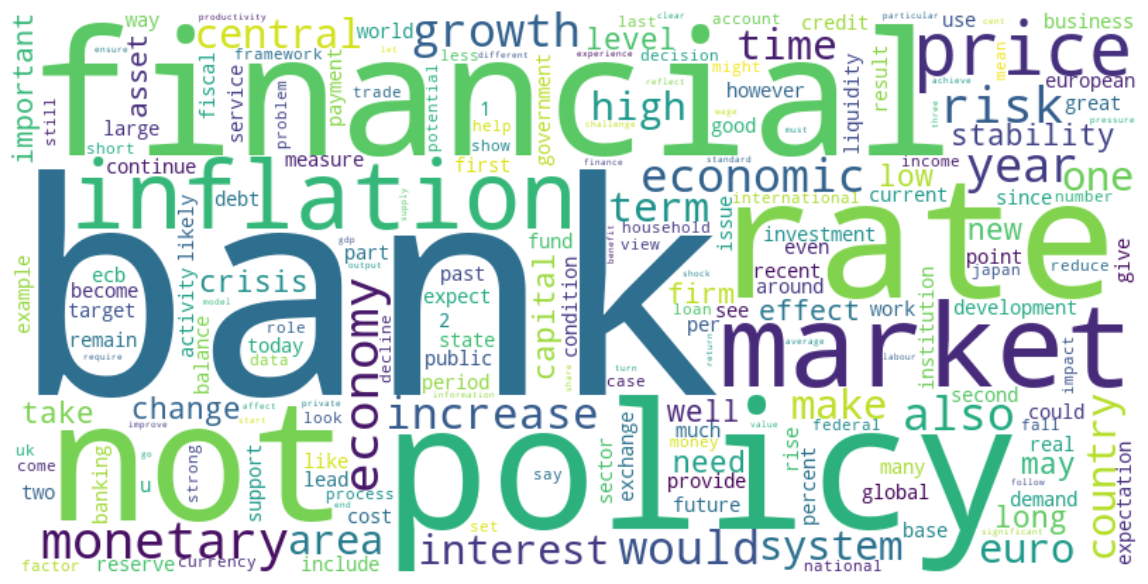

In [134]:
# Group 'review_lemmatised' to show the count per review.
speeches['text_lemmatised_str'] = speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Now call your function
plot_top_non_stopwords_wordcloud(speeches['text_lemmatised_str'])

In [135]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

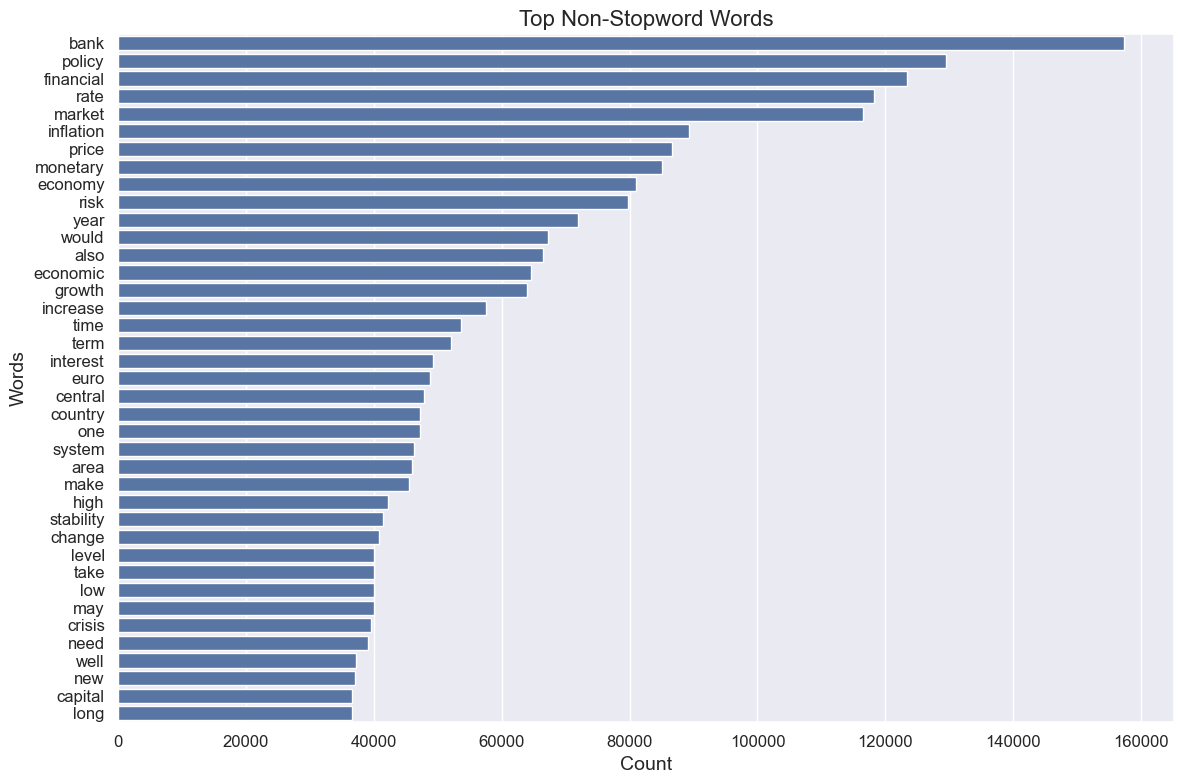

In [136]:
# Group 'review_lemmatised' to show the count per review.
speeches['text_lemmatised_str'] = speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Create bar chart
top_words_barchart(speeches['text_lemmatised_str'])

In [137]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

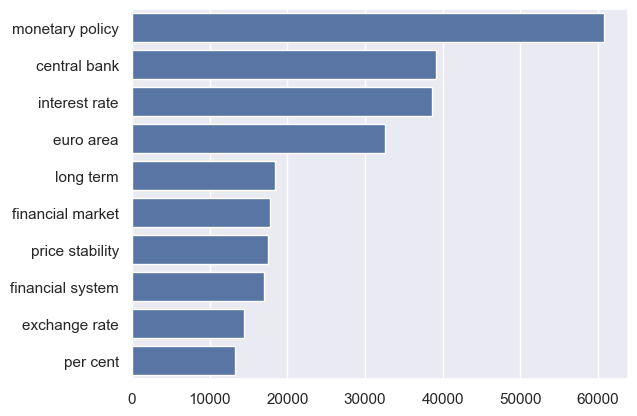

In [138]:
# Plot top phrases with 2 words
top_word_group_barchart(speeches['text_lemmatised_str'],2)

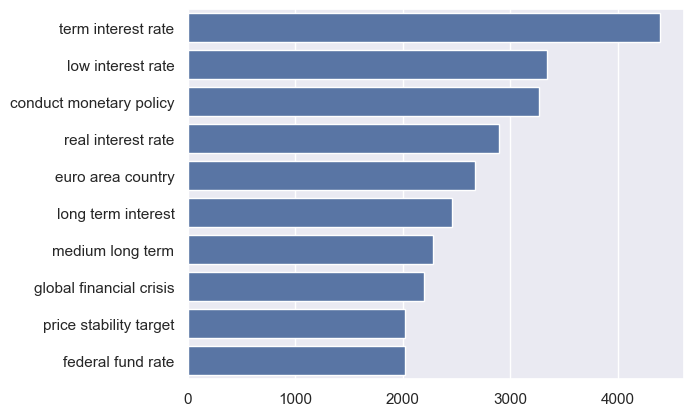

In [139]:
# Plot top phrases with 3 words
top_word_group_barchart(speeches['text_lemmatised_str'],3)

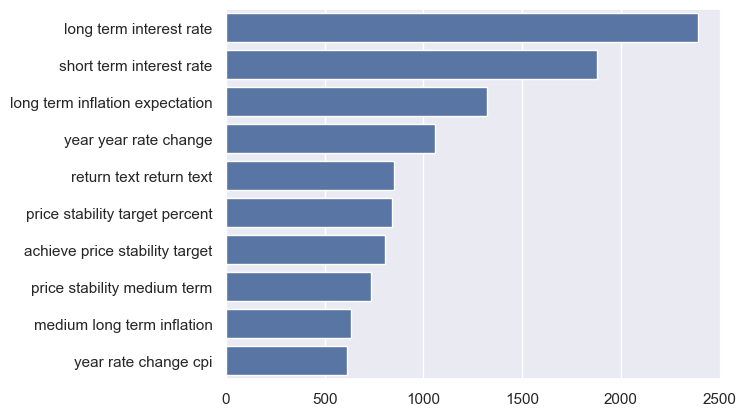

In [140]:
# Plot top phrases with 4 words
top_word_group_barchart(speeches['text_lemmatised_str'],4)

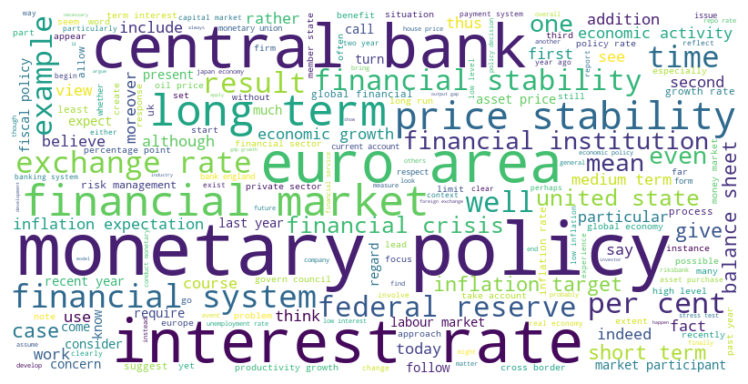

In [141]:
# Convert tokens into a single string.
speeches_text = ' '.join(speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

### 3.3. Sentiment Analysis using VADER Sentiment Intensity Analyzer for BoE speeches

In [144]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned,text_tokenised,text_lemmatised,text_lemmatised_str
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,thank chairman actually pleased opportunity re...,"[thank, chairman, actually, pleased, opportuni...","[thank, chairman, actually, pleased, opportuni...",thank chairman actually pleased opportunity re...
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,great pleasure beautiful city bruges honoured ...,"[great, pleasure, beautiful, city, bruges, hon...","[great, pleasure, beautiful, city, bruges, hon...",great pleasure beautiful city bruges honour op...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,industries suffered volatility british economy...,"[industries, suffered, volatility, british, ec...","[industry, suffer, volatility, british, econom...",industry suffer volatility british economy pas...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,topic evening use forecasts economic policy ma...,"[topic, evening, use, forecasts, economic, pol...","[topic, evening, use, forecast, economic, poli...",topic evening use forecast economic policy mak...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,six years ago week sterling left exchange rate...,"[six, years, ago, week, sterling, left, exchan...","[six, year, ago, week, sterling, leave, exchan...",six year ago week sterling leave exchange rate...


In [145]:
# View column types.
boe_speeches.dtypes

reference                      object
country                        object
date                           object
title                          object
author                         object
is_gov                          int64
text                           object
date_format            datetime64[ns]
year_month                  period[M]
year                            int32
text_cleaned                   object
text_tokenised                 object
text_lemmatised                object
text_lemmatised_str            object
dtype: object

VADER categorises reviews as positive, negative, or neutral sentiments based on its emotional tone.

In [147]:
# Apply sentiment analysis to the columns using the lemmatised data converted into strings.
boe_speeches['sentiment_score'] = boe_speeches['text_lemmatised'].apply(analyse_sentiment)

# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned,text_tokenised,text_lemmatised,text_lemmatised_str,sentiment_score
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,thank chairman actually pleased opportunity re...,"[thank, chairman, actually, pleased, opportuni...","[thank, chairman, actually, pleased, opportuni...",thank chairman actually pleased opportunity re...,"{'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp..."
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,great pleasure beautiful city bruges honoured ...,"[great, pleasure, beautiful, city, bruges, hon...","[great, pleasure, beautiful, city, bruges, hon...",great pleasure beautiful city bruges honour op...,"{'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co..."
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,industries suffered volatility british economy...,"[industries, suffered, volatility, british, ec...","[industry, suffer, volatility, british, econom...",industry suffer volatility british economy pas...,"{'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co..."
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,topic evening use forecasts economic policy ma...,"[topic, evening, use, forecasts, economic, pol...","[topic, evening, use, forecast, economic, poli...",topic evening use forecast economic policy mak...,"{'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co..."
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,six years ago week sterling left exchange rate...,"[six, years, ago, week, sterling, left, exchan...","[six, year, ago, week, sterling, leave, exchan...",six year ago week sterling leave exchange rate...,"{'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co..."


In [148]:
# Extract individual sentiment scores for speeches.
boe_speeches['text_neg'] = boe_speeches['sentiment_score'].apply(lambda x: x['neg'])
boe_speeches['text_neu'] = boe_speeches['sentiment_score'].apply(lambda x: x['neu'])
boe_speeches['text_pos'] = boe_speeches['sentiment_score'].apply(lambda x: x['pos'])
boe_speeches['text_compound'] = boe_speeches['sentiment_score'].apply(lambda x: x['compound'])

In [149]:
# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned,text_tokenised,text_lemmatised,text_lemmatised_str,sentiment_score,text_neg,text_neu,text_pos,text_compound
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,thank chairman actually pleased opportunity re...,"[thank, chairman, actually, pleased, opportuni...","[thank, chairman, actually, pleased, opportuni...",thank chairman actually pleased opportunity re...,"{'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...",0.143,0.700,0.157,0.9898
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,great pleasure beautiful city bruges honoured ...,"[great, pleasure, beautiful, city, bruges, hon...","[great, pleasure, beautiful, city, bruges, hon...",great pleasure beautiful city bruges honour op...,"{'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...",0.094,0.684,0.222,0.9998
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,industries suffered volatility british economy...,"[industries, suffered, volatility, british, ec...","[industry, suffer, volatility, british, econom...",industry suffer volatility british economy pas...,"{'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...",0.106,0.732,0.161,0.9969
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,topic evening use forecasts economic policy ma...,"[topic, evening, use, forecasts, economic, pol...","[topic, evening, use, forecast, economic, poli...",topic evening use forecast economic policy mak...,"{'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...",0.078,0.784,0.139,0.9993
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,six years ago week sterling left exchange rate...,"[six, years, ago, week, sterling, left, exchan...","[six, year, ago, week, sterling, leave, exchan...",six year ago week sterling leave exchange rate...,"{'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...",0.093,0.783,0.124,0.9984


In [150]:
# Categories VADER sentiment according to compound_score
def vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment labels to speeches
boe_speeches['vader_sentiment_score'] = boe_speeches['text_compound'].apply(vader_sentiment)

# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,text_cleaned,text_tokenised,text_lemmatised,text_lemmatised_str,sentiment_score,text_neg,text_neu,text_pos,text_compound,vader_sentiment_score
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,thank chairman actually pleased opportunity re...,"[thank, chairman, actually, pleased, opportuni...","[thank, chairman, actually, pleased, opportuni...",thank chairman actually pleased opportunity re...,"{'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...",0.143,0.700,0.157,0.9898,Positive
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,great pleasure beautiful city bruges honoured ...,"[great, pleasure, beautiful, city, bruges, hon...","[great, pleasure, beautiful, city, bruges, hon...",great pleasure beautiful city bruges honour op...,"{'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...",0.094,0.684,0.222,0.9998,Positive
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,industries suffered volatility british economy...,"[industries, suffered, volatility, british, ec...","[industry, suffer, volatility, british, econom...",industry suffer volatility british economy pas...,"{'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...",0.106,0.732,0.161,0.9969,Positive
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,topic evening use forecasts economic policy ma...,"[topic, evening, use, forecasts, economic, pol...","[topic, evening, use, forecast, economic, poli...",topic evening use forecast economic policy mak...,"{'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...",0.078,0.784,0.139,0.9993,Positive
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,six years ago week sterling left exchange rate...,"[six, years, ago, week, sterling, left, exchan...","[six, year, ago, week, sterling, leave, exchan...",six year ago week sterling leave exchange rate...,"{'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...",0.093,0.783,0.124,0.9984,Positive


In [151]:
# Average VADER Sentiment per year
vader_yearly = (
    boe_speeches
      .groupby('year')[['text_compound', 'text_pos', 'text_neg', 'text_neu']]
      .mean()
      .round(3)                
)

# Display the table
print("\nAverage VADER sentiment per year:")
vader_yearly


Average VADER sentiment per year:


,text_compound,text_pos,text_neg,text_neu
year,,,,
1998,0.997,0.161,0.107,0.732
1999,0.932,0.175,0.098,0.727
2000,0.943,0.201,0.089,0.710
2001,0.941,0.179,0.104,0.717
2002,0.932,0.189,0.104,0.707
2003,0.789,0.181,0.100,0.718
2004,0.803,0.176,0.091,0.733
2005,0.998,0.170,0.092,0.738
2006,0.876,0.175,0.098,0.727


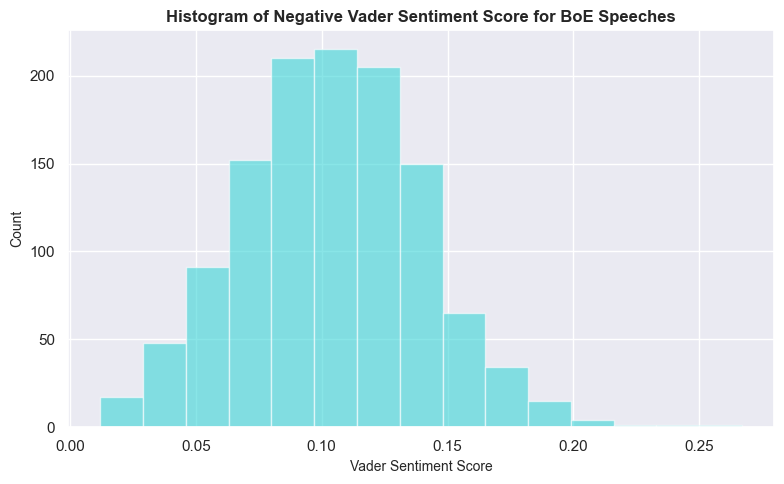

In [152]:
# Plot a histogram of the negative sentiment score
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_neg'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Vader Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Negative Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

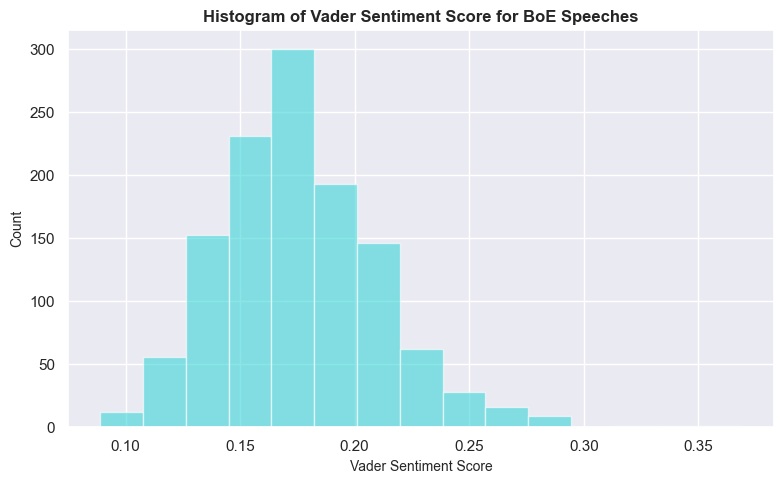

In [153]:
# Plot a histogram of the negative sentiment score
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_pos'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Vader Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

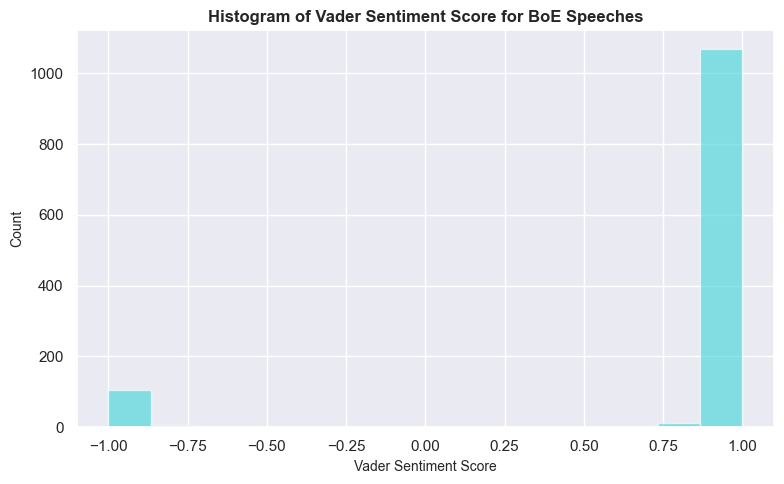

In [154]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_compound'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Vader Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.4. Review Polarity and Subjectivity using TextBlob for BoE speeches

In [156]:
# Populate a new column with polarity scores for each comment.
boe_speeches['polarity_score'] = boe_speeches['text_lemmatised_str'].apply(generate_polarity)

# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,text_tokenised,text_lemmatised,text_lemmatised_str,sentiment_score,text_neg,text_neu,text_pos,text_compound,vader_sentiment_score,polarity_score
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,"[thank, chairman, actually, pleased, opportuni...","[thank, chairman, actually, pleased, opportuni...",thank chairman actually pleased opportunity re...,"{'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...",0.143,0.700,0.157,0.9898,Positive,0.050647
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,"[great, pleasure, beautiful, city, bruges, hon...","[great, pleasure, beautiful, city, bruges, hon...",great pleasure beautiful city bruges honour op...,"{'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...",0.094,0.684,0.222,0.9998,Positive,0.062814
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,"[industries, suffered, volatility, british, ec...","[industry, suffer, volatility, british, econom...",industry suffer volatility british economy pas...,"{'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...",0.106,0.732,0.161,0.9969,Positive,0.045922
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,"[topic, evening, use, forecasts, economic, pol...","[topic, evening, use, forecast, economic, poli...",topic evening use forecast economic policy mak...,"{'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...",0.078,0.784,0.139,0.9993,Positive,0.041968
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,"[six, years, ago, week, sterling, left, exchan...","[six, year, ago, week, sterling, leave, exchan...",six year ago week sterling leave exchange rate...,"{'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...",0.093,0.783,0.124,0.9984,Positive,0.048576


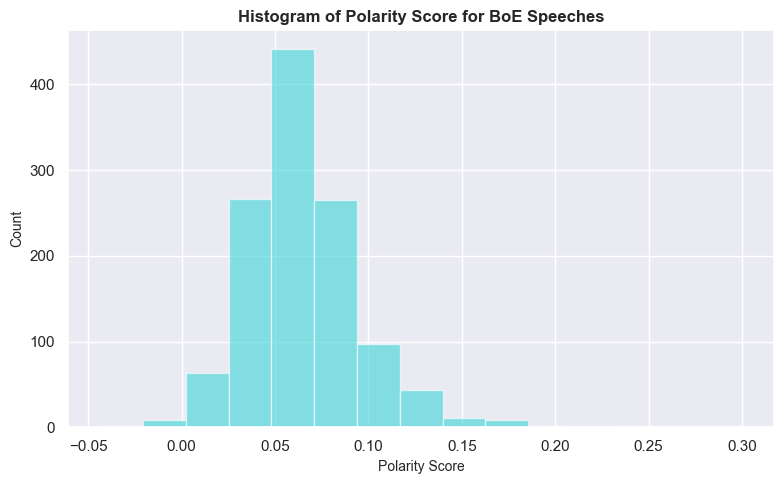

In [157]:
# Plot a histogram of the polarity score for reviews.
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['polarity_score'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Polarity Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Polarity Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [158]:
# Populate a new column with polarity scores for each comment.
boe_speeches['subjectivity_score'] = boe_speeches['text_lemmatised_str'].apply(generate_subjectivity)

# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,text_lemmatised,text_lemmatised_str,sentiment_score,text_neg,text_neu,text_pos,text_compound,vader_sentiment_score,polarity_score,subjectivity_score
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,"[thank, chairman, actually, pleased, opportuni...",thank chairman actually pleased opportunity re...,"{'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...",0.143,0.700,0.157,0.9898,Positive,0.050647,0.417626
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,"[great, pleasure, beautiful, city, bruges, hon...",great pleasure beautiful city bruges honour op...,"{'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...",0.094,0.684,0.222,0.9998,Positive,0.062814,0.351627
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,"[industry, suffer, volatility, british, econom...",industry suffer volatility british economy pas...,"{'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...",0.106,0.732,0.161,0.9969,Positive,0.045922,0.376753
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,"[topic, evening, use, forecast, economic, poli...",topic evening use forecast economic policy mak...,"{'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...",0.078,0.784,0.139,0.9993,Positive,0.041968,0.462368
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,"[six, year, ago, week, sterling, leave, exchan...",six year ago week sterling leave exchange rate...,"{'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...",0.093,0.783,0.124,0.9984,Positive,0.048576,0.389893


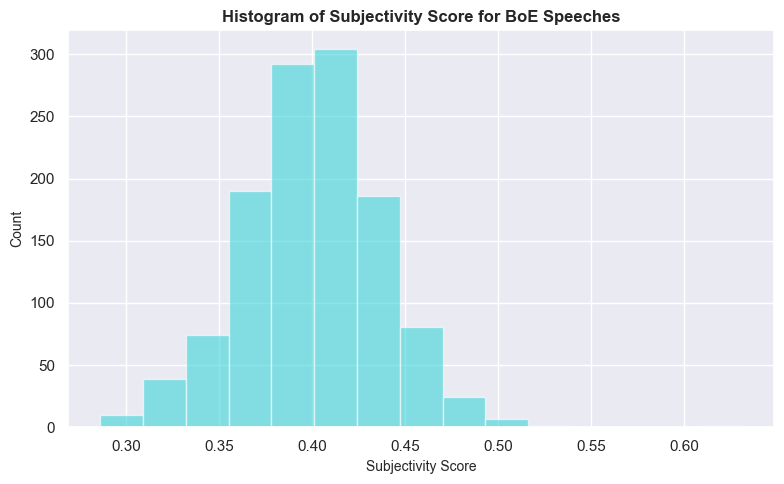

In [159]:
# Plot a histogram of the polarity score for summary.
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['subjectivity_score'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Subjectivity Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Subjectivity Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.5. Sentiment Analysis with BoE Sentiment Wordlist for BoE speeches

In [162]:
# Prepare the lexicon
sentiment_lexicon = sentiment_lexicon.copy()

# Define categories
categories = [
     'Negative',
     'Positive',
     'Uncertainty',
     'Litigious',
     'Strong',
     'Weak',
     'Constraining',
 ]

# Create dictionary of categories, containing words that belong to that category based on your sentiment lexicon.
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [163]:
# Define function to apply the lexicon to the text
def lexicon_counts(tokens):
    return pd.Series({
        cat: sum(t in word_sets[cat] for t in tokens)
        for cat in categories
    })

# Compute counts and add new columns for each category
boe_speeches = pd.concat(
    [boe_speeches, boe_speeches['text_lemmatised'].apply(lexicon_counts)], axis=1
 )

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,vader_sentiment_score,polarity_score,subjectivity_score,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,Positive,0.050647,0.417626,62,39,24,3,14,16,2
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,Positive,0.062814,0.351627,80,88,51,6,10,28,17
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,Positive,0.045922,0.376753,63,32,49,2,3,15,6
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,Positive,0.041968,0.462368,79,42,91,12,14,42,15
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,Positive,0.048576,0.389893,102,46,113,22,13,48,12


In [164]:
# Calculate the sentiment score by subtracting the negative score from the positive score
boe_speeches['sentiment_score_lexicon_simple'] = boe_speeches['Positive'] - boe_speeches['Negative'] 

# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,polarity_score,subjectivity_score,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining,sentiment_score_lexicon_simple
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,0.050647,0.417626,62,39,24,3,14,16,2,-23
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,0.062814,0.351627,80,88,51,6,10,28,17,8
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,0.045922,0.376753,63,32,49,2,3,15,6,-31
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,0.041968,0.462368,79,42,91,12,14,42,15,-37
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,0.048576,0.389893,102,46,113,22,13,48,12,-56


**Weighted Sentiment Score using Sentiment Lexicon**<br>
Assign weights to categories based on their importance or strength:
- Positive	    +1	    Standard positive words.
- Negative	    -1	    Standard negative words.
- Uncertainty	-0.5	Words expressing doubt or ambiguity, less impactful than outright negative or positive words.
- Litigious	    -0.8	Words related to lawsuits or legal issues, potentially negative or impactful depending on context.
- Strong	    +1.5	Words with high intensity or impact, thus given more weight.
- Weak	        +0.5	Words with less impact, so given lesser weight than 'Strong' words.
- Constraining	-1	    Words implying restriction or limitations, generally negative.

In [166]:
# Assign weights to the categories
category_weights = {
    'Negative': -1,
    'Positive': 1,
    'Uncertainty': -0.5,
    'Litigious': -0.8,
    'Strong': 1.5,
    'Weak': 0.5,
    'Constraining': -1
}

In [167]:
# Define function to apply the lexicon to the text
def lexicon_score_weighted(tokens):
    score = 0
    for cat in categories:
        count = sum(t in word_sets[cat] for t in tokens)
        score += count * category_weights[cat]
    return score

# Compute counts and store as a new column
boe_speeches['sentiment_score_lexicon_weighted'] = boe_speeches['text_lemmatised'].apply(lexicon_score_weighted)

# View the DataFrame
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,subjectivity_score,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining,sentiment_score_lexicon_simple,sentiment_score_lexicon_weighted
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,0.417626,62,39,24,3,14,16,2,-23,-10.4
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,0.351627,80,88,51,6,10,28,17,8,-10.3
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,0.376753,63,32,49,2,3,15,6,-31,-51.1
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,0.462368,79,42,91,12,14,42,15,-37,-65.1
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,0.389893,102,46,113,22,13,48,12,-56,-98.6


### 3.6. Sentiment Analysis with Loughran-McDonald Master Dictionary for BoE speeches

In [169]:
# Prepare the lexicon
loughran_mcdonald = loughran_mcdonald_dict.copy()

categories = [
     'negative_lm',
     'positive_lm',
     'uncertainty_lm',
     'litigious_lm',
     'strong_lm',
     'weak_lm',
     'constraining_lm',
 ]

word_sets = {
    cat: set(loughran_mcdonald.loc[loughran_mcdonald[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [170]:
# Compute counts and add new columns for each category
boe_speeches = pd.concat(
    [boe_speeches, boe_speeches['text_lemmatised'].apply(lexicon_counts)], axis=1
 )

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,Constraining,sentiment_score_lexicon_simple,sentiment_score_lexicon_weighted,negative_lm,positive_lm,uncertainty_lm,litigious_lm,strong_lm,weak_lm,constraining_lm
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,2,-23,-10.4,61,23,24,3,14,16,2
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,17,8,-10.3,79,69,51,6,10,28,17
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,6,-31,-51.1,59,11,49,2,3,15,6
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,15,-37,-65.1,77,39,91,12,14,42,15
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,12,-56,-98.6,101,33,113,22,13,48,12


In [171]:
# Calculate the sentiment score by subtracting the negative score from the positive score
boe_speeches['sentiment_score_lm_simple'] = boe_speeches['positive_lm'] - boe_speeches['negative_lm'] 

# View the DataFrame.
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,sentiment_score_lexicon_simple,sentiment_score_lexicon_weighted,negative_lm,positive_lm,uncertainty_lm,litigious_lm,strong_lm,weak_lm,constraining_lm,sentiment_score_lm_simple
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,-23,-10.4,61,23,24,3,14,16,2,-38
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,8,-10.3,79,69,51,6,10,28,17,-10
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,-31,-51.1,59,11,49,2,3,15,6,-48
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,-37,-65.1,77,39,91,12,14,42,15,-38
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,-56,-98.6,101,33,113,22,13,48,12,-68


**Weighted Sentiment Score using Sentiment Lexicon**<br>
Assign weights to categories based on their importance or strength:
- Positive	    +1	    Standard positive words.
- Negative	    -1	    Standard negative words.
- Uncertainty	-0.5	Words expressing doubt or ambiguity, less impactful than outright negative or positive words.
- Litigious	    -0.8	Words related to lawsuits or legal issues, potentially negative or impactful depending on context.
- Strong	    +1.5	Words with high intensity or impact, thus given more weight.
- Weak	        +0.5	Words with less impact, so given lesser weight than 'Strong' words.
- Constraining	-1	    Words implying restriction or limitations, generally negative.

In [173]:
# Define weights for each category
category_weights = {
    'negative_lm': -1,
    'positive_lm': 1,
    'uncertainty_lm': -0.5,
    'litigious_lm': -0.8,
    'strong_lm': 1.5,
    'weak_lm': 0.5,
    'constraining_lm': -1
}

In [174]:
# Compute counts and store as a new column
boe_speeches['sentiment_score_lm_weighted'] = boe_speeches['text_lemmatised'].apply(lexicon_score_weighted)

# View the DataFrame
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,sentiment_score_lexicon_weighted,negative_lm,positive_lm,uncertainty_lm,litigious_lm,strong_lm,weak_lm,constraining_lm,sentiment_score_lm_simple,sentiment_score_lm_weighted
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,-10.4,61,23,24,3,14,16,2,-38,-25.4
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,-10.3,79,69,51,6,10,28,17,-10,-28.3
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,-51.1,59,11,49,2,3,15,6,-48,-68.1
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,-65.1,77,39,91,12,14,42,15,-38,-66.1
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,-98.6,101,33,113,22,13,48,12,-68,-110.6


In [175]:
# View the weighted Sentiment scores.
boe_speeches['sentiment_score_lm_weighted'].describe()

count    1209.000000
mean      -88.747395
std       113.138490
min     -1498.000000
25%      -116.800000
50%       -67.200000
75%       -30.600000
max       242.700000
Name: sentiment_score_lm_weighted, dtype: float64

### 3.8. Sentiment Analysis with FinBERT for BoE speeches

In [285]:
# Define a function to predict probabilities in batches
def predict_batch(texts, tokenizer, model, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')  # Tokenize batch of texts
    inputs = {k: v.to(device) for k, v in inputs.items()}                 # Move inputs to the device (GPU or CPU)
    with torch.no_grad():                                                 # Get model outputs without computing gradients
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)                              # Convert logits to probabilities
    return probs.cpu().numpy()

**3.8.a. Apply ProsusAI Model**

In [326]:
# Check the order of the labels in the ProsusAI model
model_prosus.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [328]:
# Column that the model should be applied to
texts = boe_speeches['text_lemmatised'].astype(str).tolist()

# Specify batch size for efficiency
batch_size = 32
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_probs = predict_batch(batch_texts, tokenizer_prosus, model_prosus)
    all_probs.extend(batch_probs)

# Store the predicted probabilities back into your DataFrame
boe_speeches['prosus_probs'] = all_probs

# Extract top labels using the order established above
labels = ['positive', 'negative', 'neutral']

def get_top_label(probs):
    idx = probs.argmax()
    return labels[idx], probs.max()

In [321]:
# Extracts top predicted label and confidence scores and adds those as two new columns: 
boe_speeches[['prosus_label', 'prosus_confidence']] = boe_speeches['prosus_probs'].apply(lambda x: get_top_label(x)).apply(pd.Series)

In [323]:
# View the DataFrame
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,weak_lm,constraining_lm,sentiment_score_lm_simple,sentiment_score_lm_weighted,prosus_probs,prosus_label,prosus_confidence,yiyang_probs,yiyang_label,yiyang_confidence
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,16,2,-38,-25.4,"[0.036668405, 0.030295398, 0.93303627]",neutral,0.933036,"[0.4900095, 0.5094528, 0.00053772976]",neutral,0.509453
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,28,17,-10,-28.3,"[0.037443813, 0.02975993, 0.9327963]",neutral,0.932796,"[0.969261, 0.030696781, 4.2198746e-05]",positive,0.969261
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,15,6,-48,-68.1,"[0.026425917, 0.09654963, 0.8770244]",neutral,0.877024,"[0.37933072, 0.021060491, 0.5996088]",negative,0.599609
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,42,15,-38,-66.1,"[0.03381174, 0.03339488, 0.9327934]",neutral,0.932793,"[0.9847193, 0.0149205, 0.00036025542]",positive,0.984719
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,48,12,-68,-110.6,"[0.037178747, 0.042529326, 0.9202919]",neutral,0.920292,"[0.9990752, 0.0009056315, 1.9160354e-05]",positive,0.999075


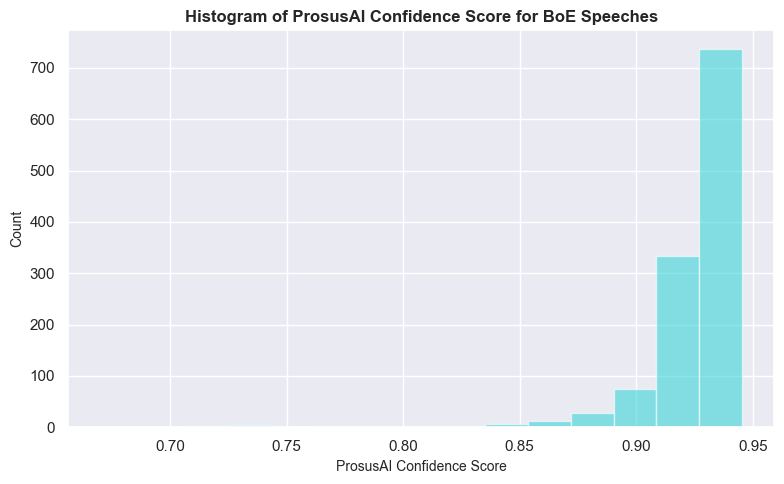

In [351]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['prosus_confidence'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('ProsusAI Confidence Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of ProsusAI Confidence Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [353]:
# View the weighted Sentiment scores.
boe_speeches['prosus_probs'].describe()

count                                       1209
unique                                      1209
top       [0.036668405, 0.030295398, 0.93303627]
freq                                           1
Name: prosus_probs, dtype: object

In [354]:
# View the weighted Sentiment scores.
boe_speeches['prosus_label'].nunique()

1

In [357]:
# View the weighted Sentiment scores.
boe_speeches['prosus_confidence'].describe()

count    1209.000000
mean        0.923436
std         0.025394
min         0.670076
25%         0.921743
50%         0.930312
75%         0.934870
max         0.945375
Name: prosus_confidence, dtype: float64

**3.8.b. Apply yiyanghkust model**

In [331]:
model_yiyang.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [333]:
# Column that the model should be applied to
texts = boe_speeches['text_lemmatised'].astype(str).tolist()

# Specify batch size for efficiency
batch_size = 32
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_probs = predict_batch(batch_texts, tokenizer_yiyang, model_yiyang)
    all_probs.extend(batch_probs)

# Store the predicted probabilities back into your DataFrame
boe_speeches['yiyang_probs'] = all_probs

# Extract top labels using the order established above
labels = ['neutral', 'positive', 'negative']

def get_top_label(probs):
    idx = probs.argmax()
    return labels[idx], probs.max()

In [335]:
boe_speeches[['yiyang_label', 'yiyang_confidence']] = boe_speeches['yiyang_probs'].apply(lambda x: get_top_label(x)).apply(pd.Series)

# Now, your DataFrame has the probabilities, top label, and confidence score
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,date_format,year_month,year,...,weak_lm,constraining_lm,sentiment_score_lm_simple,sentiment_score_lm_weighted,prosus_probs,prosus_label,prosus_confidence,yiyang_probs,yiyang_label,yiyang_confidence
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",1998-09-15,1998-09,1998,...,16,2,-38,-25.4,"[0.036668405, 0.030295398, 0.93303627]",neutral,0.933036,"[0.4900095, 0.5094528, 0.00053772976]",positive,0.509453
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,1998-10-21,1998-10,1998,...,28,17,-10,-28.3,"[0.037443813, 0.02975993, 0.9327963]",neutral,0.932796,"[0.969261, 0.030696781, 4.2198746e-05]",neutral,0.969261
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998-10-21,1998-10,1998,...,15,6,-48,-68.1,"[0.026425917, 0.09654963, 0.8770244]",neutral,0.877024,"[0.37933072, 0.021060491, 0.5996088]",negative,0.599609
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998-11-01,1998-11,1998,...,42,15,-38,-66.1,"[0.03381174, 0.03339488, 0.9327934]",neutral,0.932793,"[0.9847193, 0.0149205, 0.00036025542]",neutral,0.984719
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998-11-01,1998-11,1998,...,48,12,-68,-110.6,"[0.037178747, 0.042529326, 0.9202919]",neutral,0.920292,"[0.9990752, 0.0009056315, 1.9160354e-05]",neutral,0.999075


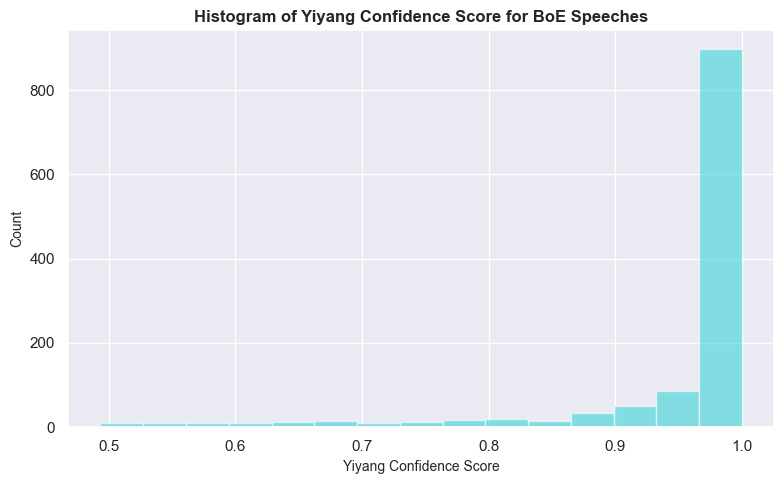

In [359]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['yiyang_confidence'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Yiyang Confidence Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Yiyang Confidence Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [255]:
# View the weighted Sentiment scores.
boe_speeches['yiyang_probs'].describe()

count                                      1209
unique                                     1209
top       [0.4900095, 0.5094528, 0.00053772976]
freq                                          1
Name: yiyang_probs, dtype: object

In [345]:
# View the weighted Sentiment scores.
boe_speeches['yiyang_label'].nunique()

3

In [339]:
# View the weighted Sentiment scores.
boe_speeches['yiyang_confidence'].describe()

count    1209.000000
mean        0.950838
std         0.101343
min         0.493483
25%         0.964171
50%         0.994892
75%         0.999078
max         1.000000
Name: yiyang_confidence, dtype: float64

In [309]:
# Export the DataFrame to an Excel file
boe_speeches.to_excel('boe_speeches.xlsx', index=False)

print("DataFrame was exported successfully.")

DataFrame was exported successfully.


### 3.7. Plot the data over time

In [ ]:
# Scatterplot for sentiment scores over time.
generate_scatterplot(boe_speeches, x_axis='year', y_axis='text_compound', title=None, hue=None, save_path=None)

## 5. Exploratory Analysis for Correlation with Economic Indicators

### 5.1. Prepare the data

In [ ]:
# List of DataFrames to merge
dataframes_to_merge = [unemployment_uk, exchange_rates_uk, inflation_uk, credit_growth_uk, bank_rates_uk, gdp_uk, confidence_uk]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches)

# View the merged DataFrame
boe_speeches_indicators.head()

In [ ]:
# Check for missing values.
boe_speeches_indicators.isnull().sum()

In [ ]:
# Explore the DataFrame.
boe_speeches_indicators.info()

### 5.2. Plot the data

In [ ]:
# Display all column names.
boe_speeches_indicators.columns

In [ ]:
boe_speeches_indicators['year_month'].dtypes

In [ ]:
# Convert 'year_month' Period to datetime
boe_speeches_indicators['date'] = boe_speeches_indicators['year_month'].dt.to_timestamp()

In [ ]:
boe_speeches_indicators['year_month'].dtypes

**Confidence Index**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['text_compound'], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER compound score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['weighted_sentiment_LM'], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['Positive', 'Negative', 'Uncertainty']], color='blue', label='Lexicom Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lexicon Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
'text_pos', 'text_neg', 'text_neu'

**Inflation**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['Neg_LM', 'Pos_LM', 'Uncertainty_LM']], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Inflation Rate'], color='red', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Inflation Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['weighted_sentiment_LM'], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Unemployment rate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Unemployment Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Interest Rates**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['weighted_sentiment_LM'], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['weighted_sentiment_LM'], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

### 5.3. Initial statistical analysis

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_lexicon = ['sentiment_score_lexicon', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_lexicon], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_lexicon = boe_speeches_indicators[columns_sentiment_lexicon].corr()

# Display the correlation matrix
correlation_matrix_lexicon

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_lexicon, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for weighted sentiment score, unemployment, inflation and exchange rates.
columns_weighted_sentiment = ['weighted_sentiment_score', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_weighted = boe_speeches_indicators[columns_weighted_sentiment].corr()

# Display the correlation matrix
correlation_matrix_weighted

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_weighted, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_vader_compound = ['text_compound', 'Unemployment rate', 'Inflation Rate', 'USD into Sterling', \
                             'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                             '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                             '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                             '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                             'Manufacturing', 'Service Industries', 'Information & Communication', \
                             'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_vader = boe_speeches_indicators[columns_vader_compound].corr()

# Display the correlation matrix
correlation_matrix_vader

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_vader, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_vader_all = ['text_compound', 'text_neg', 'text_neu', 'text_pos', 'Unemployment rate', 'Inflation Rate', \
                     'USD into Sterling', 'Japanese Yen into Sterling', 'Euro into Sterling', 'Bank Rate', \
                     '12-Month Growth of UK Consumer Credit (excl SLC, %)', \
                     '12-Month Growth of UK Consumer Credit (excl SLC & CC, %)', \
                     '12-Month Growth of Sterling Credit Cards to Individuals (%)', 'Gross Value Added', \
                     'Manufacturing', 'Service Industries', 'Information & Communication', \
                     'Financial & Insurance Activities', 'confidence_index']

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_vader_all = boe_speeches_indicators[columns_vader_all].corr()

# Display the correlation matrix
correlation_matrix_vader_all

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_vader_all, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()